# ISSk Projekt 2022/21

MAREK SOOS (xsoosm00) <br>
5kAIŘ/1<br>
16.12.2022<br>

In [1]:
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt
import scipy 
import math
import IPython
import pandas as pd
pd.set_option('display.max_rows', 200)
%matplotlib inline

## Exercise 4.1
<h3>
    <b>Základy :</b>
</h3>

Načítanie signálov s .txt súboru <br>

In [7]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
MY_TONES = [37, 53, 87]

TONE_NAMES = ['audio/a_orig.wav', 'audio/b_orig.wav', 'audio/c_orig.wav']


In [8]:
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone


Zobrazenie 3 period môjho signálu : <br>
<br>
Moje MIDI frekvencie 
<ul>
    <li>MIDI 37 </li>
    <li>MIDI 53 </li>
    <li>MIDI 87 </li>
</ul>

Zobrazenie 3 periód každého tónu. <br>
Perióda každého tónu je získaná empiricky. <br>


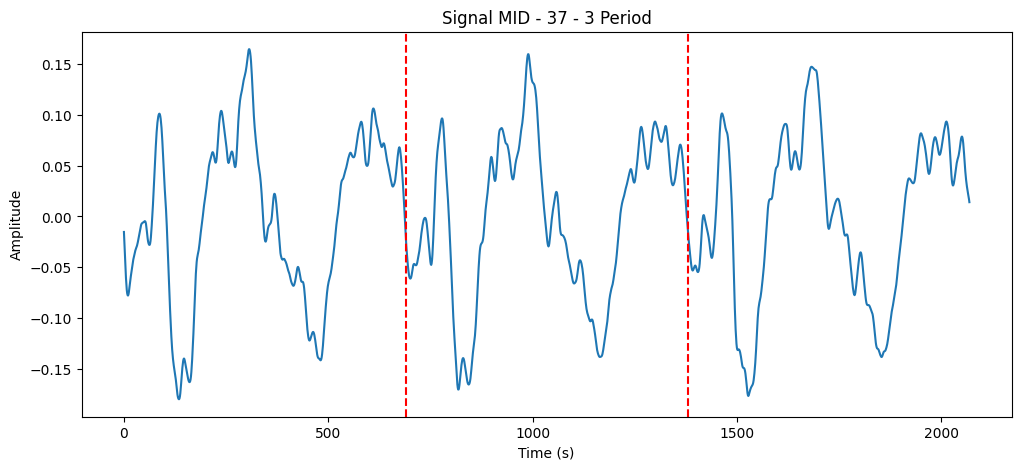

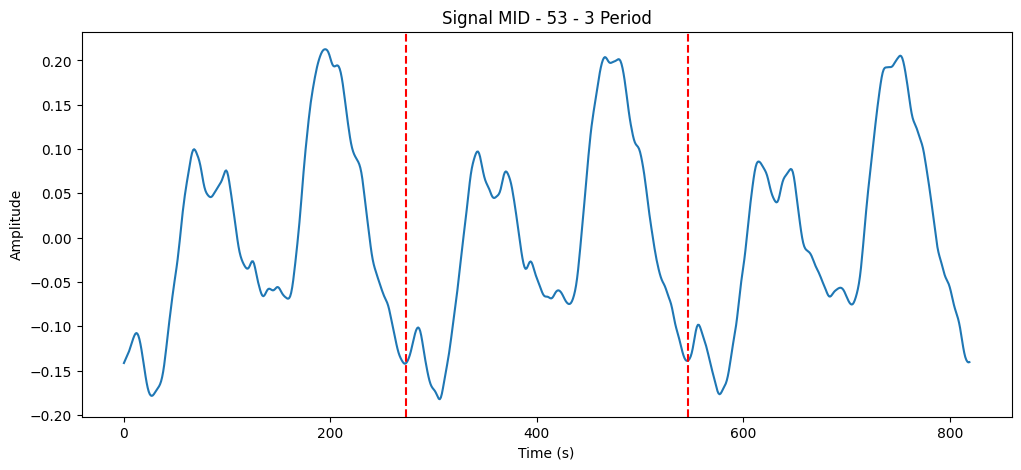

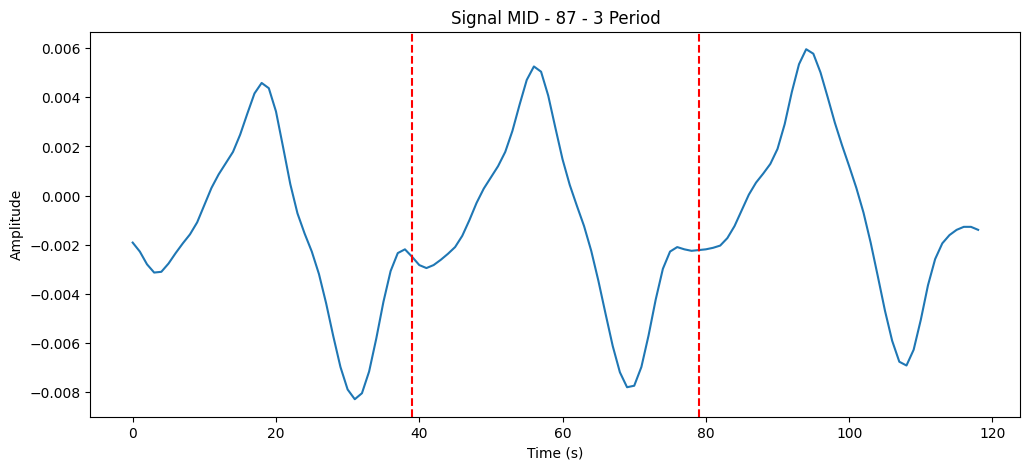

In [9]:
plt.figure(figsize=[12,5])
dataA = xall[MY_TONES[0], :2070]
plt.plot(dataA)
plt.axvline(x=2070//3,color='r', linestyle='--')
plt.axvline(x=2*2070//3,color='r', linestyle='--')
plt.title(f'Signal MID - {MY_TONES[0]} - 3 Period')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.figure(figsize=[12,5])
dataB = xall[MY_TONES[1], :820]
plt.plot(dataB)
plt.axvline(x=820//3,color='r', linestyle='--')
plt.axvline(x=2*820//3,color='r', linestyle='--')
plt.title(f'Signal MID - {MY_TONES[1]} - 3 Period')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.figure(figsize=[12,5])
dataC = xall[MY_TONES[2], :119]
plt.plot(dataC)
plt.axvline(x=119//3,color='r', linestyle='--')
plt.axvline(x=2*119//3,color='r', linestyle='--')
plt.title(f'Signal MID - {MY_TONES[2]} - 3 Period')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

plt.show()


Vykreslenie DFT - pre celý 0,5 sekundový signál, obsahujúci viacero tónov. <br>


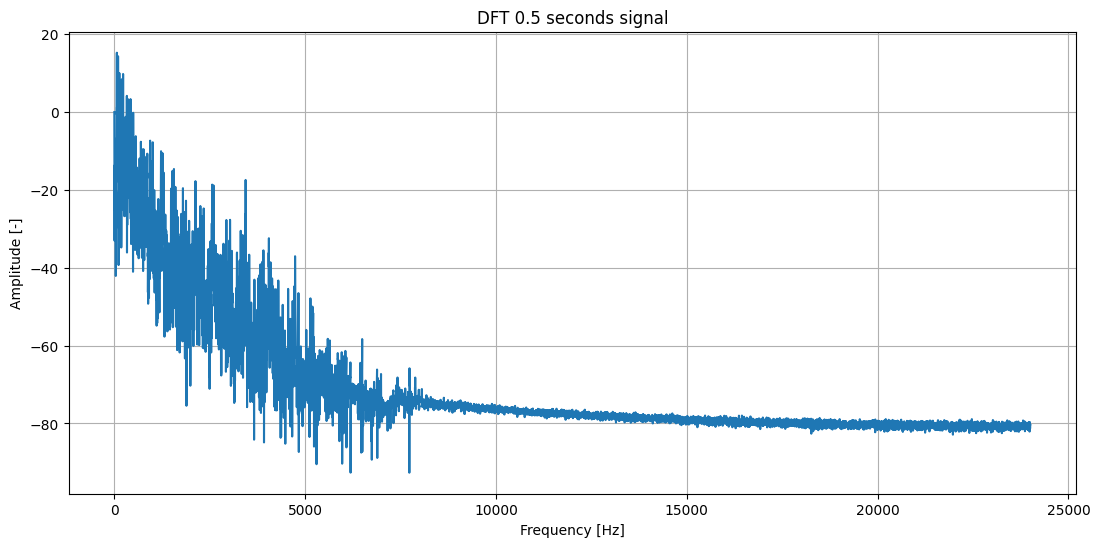

In [10]:

plt.figure(figsize=[13,6])
Y = np.fft.fft(s[:int(Fs * HOWMUCH_SEC)])
psd = 10 * np.log10(1/Y.size * np.abs(Y)**2) # TODO '10* log()' ; TODO '1/Y.size*'
psd[0] = 1e-5

frequency = np.arange(0,psd.size) / psd.size * Fs
plt.plot(frequency[:frequency.size//2],psd[:psd.size//2])
plt.title('DFT 0.5 seconds signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [-]')
plt.grid()

plt.show()


Vykreslenie DFT celého úseku 0,5 s - pre len naše signály <br>
(nebolo mi jasné zo zadania, ktorý graf/grafy sú požadavané)

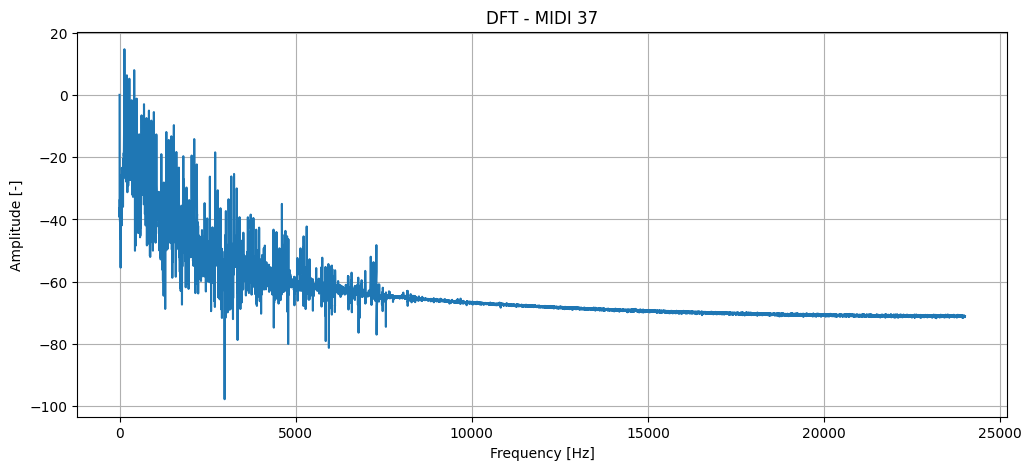

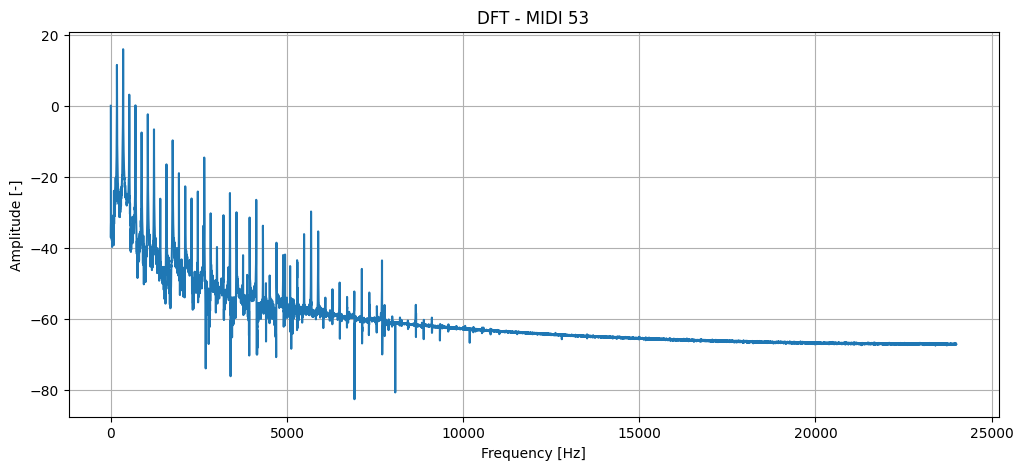

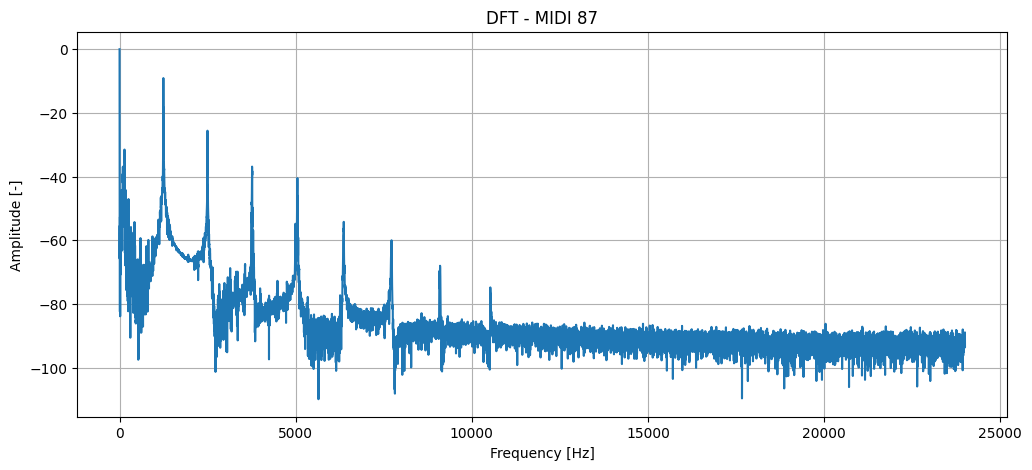

In [5]:
for tone in MY_TONES:
    plt.figure(figsize=[12,5])
    Y = np.fft.fft(xall[tone,:])
    psd = 10 * np.log10(1/Y.size * np.abs(Y)**2) 
    psd[0] = 1e-5
    frequency = np.arange(0,psd.size) / psd.size * Fs

    plt.plot(frequency[:frequency.size // 2],psd[:psd.size//2])
    plt.title('DFT - MIDI {sIdx}'.format(sIdx=tone))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [-]')
    plt.grid()
plt.show()

Uloženie signálov do :  <i>./audio/{a,b,c}_orig.wav</i>

In [11]:
for i in range(3):
    sf.write(TONE_NAMES[i], xall[MY_TONES[i],:], Fs)


## Excercise 4.2
<h3> 
    <b>Určenie základnej frekvencie :</b>
</h3>

Načítanie frekvencií obsiahnutých v <i>"midi.txt"</i> súboru.

In [12]:
# importing the MIDI frequencies from the midi.txt file
MIDI_FILE = []
midi = ''
with open("midi.txt", 'r', encoding = 'utf-8') as f:
    while(True):
        midi = f.readline()
        if not midi: 
            break
        x0 = (midi.split('\t')[0])
        x1 = (midi.split('\t')[1].split('\n')[0])
        MIDI_FILE.append([int(x0),float(x1)])
MIDI_FILE = MIDI_FILE[::-1]


Vytvorenie autokorelačnej funkcie
<br>
<br>
inšpirované : https://gist.github.com/endolith/255291

In [13]:
def freq_from_autocorr(sig, fs):
    corr = scipy.signal.correlate(sig, sig, mode="full")
    corr = corr[len(corr) // 2 :]
    d = np.diff(corr)
    start = np.nonzero(d > 0)[0][0]
    peak = np.argmax(corr[start:]) + start
    return round(fs / peak, 2)



<h5>
    Porovnanie frekvencií - MIDI vs. Autokorelácia : <br> 
</h5>
Výpočet frekvencie využitím autokorelácie. <br>
Hodnota autokorelácie bola v nižších podobná ako MIDI definovaná frekvencia. <br>
Hodnota sa líšila až pri vysokých frekvenciách, čo bol dôsledok princípu fungovania autokorelácie. <br> 
Autokorelácia funguje pre tóny s nižšími frekvenciami, naopak DFT má lepšie výsledky pre vyššie frekvencie a v nižších je nepresná.

In [14]:
fACorr = np.zeros(MIDITO+1)
for i in range(len(MIDI_FILE)):
    tIdx = MIDI_FILE[i][0]
    fsAutoCorr = freq_from_autocorr(xall[tIdx,:], Fs)
    fACorr[tIdx] = fsAutoCorr
    print("MIDI {tI} - True freq: {tF},\tAutoCorr freq : {fsA}".format(tI=tIdx, tF=MIDI_FILE[i][1], fsA=fsAutoCorr))
        

MIDI 24 - True freq: 32.7,	AutoCorr freq : 32.81
MIDI 25 - True freq: 34.65,	AutoCorr freq : 34.76
MIDI 26 - True freq: 36.71,	AutoCorr freq : 36.84
MIDI 27 - True freq: 38.89,	AutoCorr freq : 39.02
MIDI 28 - True freq: 41.2,	AutoCorr freq : 41.34
MIDI 29 - True freq: 43.65,	AutoCorr freq : 43.8
MIDI 30 - True freq: 46.25,	AutoCorr freq : 46.42
MIDI 31 - True freq: 49.0,	AutoCorr freq : 49.18
MIDI 32 - True freq: 51.91,	AutoCorr freq : 52.12
MIDI 33 - True freq: 55.0,	AutoCorr freq : 55.17
MIDI 34 - True freq: 58.27,	AutoCorr freq : 58.47
MIDI 35 - True freq: 61.74,	AutoCorr freq : 61.94
MIDI 36 - True freq: 65.41,	AutoCorr freq : 65.57
MIDI 37 - True freq: 69.3,	AutoCorr freq : 69.46
MIDI 38 - True freq: 73.42,	AutoCorr freq : 73.62
MIDI 39 - True freq: 77.78,	AutoCorr freq : 77.92
MIDI 40 - True freq: 82.41,	AutoCorr freq : 82.62
MIDI 41 - True freq: 87.31,	AutoCorr freq : 87.75
MIDI 42 - True freq: 92.5,	AutoCorr freq : 92.84
MIDI 43 - True freq: 98.0,	AutoCorr freq : 98.36
MIDI 44 

<h5>
    Metoda autokorelácie porovnaná s DTF pre 3 MIDI signály. <br>
</h5>
Rozdielne hodnoty sú spôsobené odlišným prístupom fungovania daných metod. <br>
Autokorelácia funguje lepšie na nižších frekvenciách. <br>
DTF funguje lepšie pre vyšších frekvenciách. <br>


MIDI 37 	True frequency f0[Hz] 69.3	 Autocorrelation f0[Hz] 69.46   	 DFT f0[Hz] 138.0
MIDI 53 	True frequency f0[Hz] 174.61	 Autocorrelation f0[Hz] 175.18   	 DFT f0[Hz] 350.0
MIDI 87 	True frequency f0[Hz] 1244.51	 Autocorrelation f0[Hz] 1230.77   	 DFT f0[Hz] 1244.0


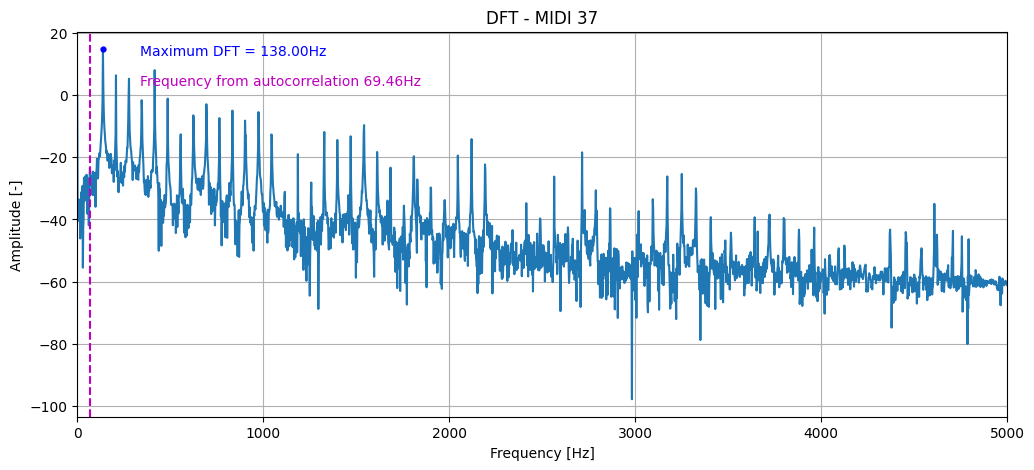

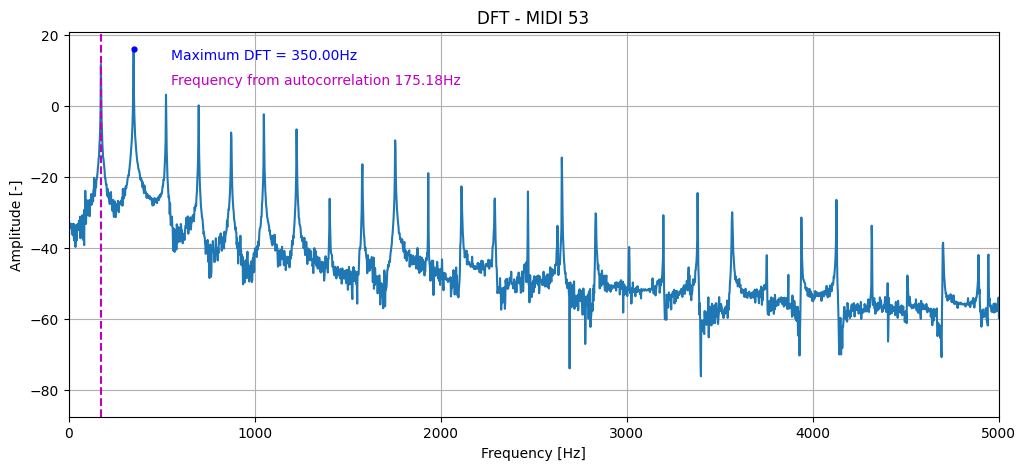

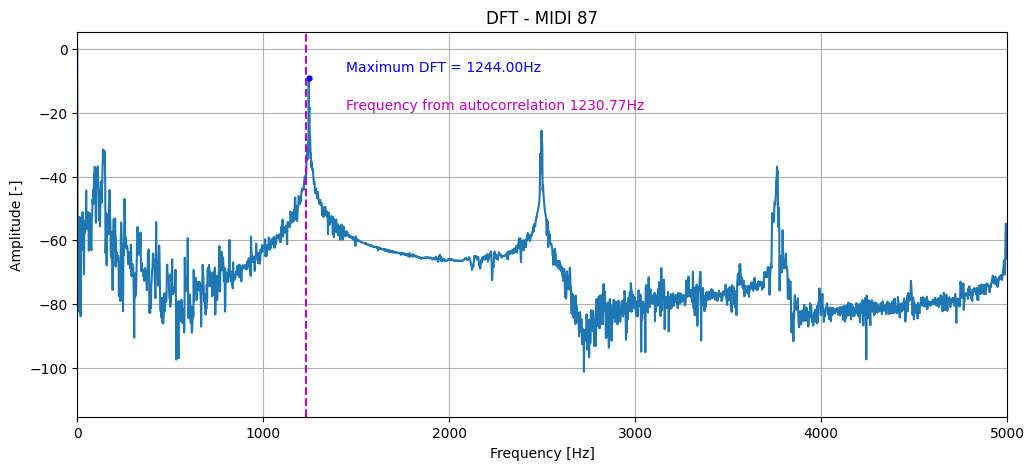

In [15]:

for tone in MY_TONES:
    plt.figure(figsize=[12,5])
    Y = np.fft.fft(xall[tone,:])
    psd = 10 * np.log10(1/Y.size * np.abs(Y)**2) 
    frequency = np.arange(0,psd.size) / psd.size * Fs

    index = np.where(np.max(psd) == psd)
    index = index[0][0]
    psd[0] = 1e-5
    
    
    print(f'MIDI {MIDI_FILE[tone-24][0]} \tTrue frequency f0[Hz] {MIDI_FILE[tone-24][1]}\t Autocorrelation f0[Hz] {fACorr[tone]}   \t DFT f0[Hz] {frequency[index]}')

    plt.plot(frequency[:frequency.size//2],psd[:psd.size//2])
    plt.title('DFT - MIDI {sIdx}'.format(sIdx=tone))    
    plt.plot(frequency[index], psd[index], 'b.', markersize=7)
    plt.text(frequency[index]+200, psd[index] - psd[index]//5, f'Maximum DFT = {frequency[index]:.2f}Hz', color='b')
    plt.text(frequency[index]+200, int(psd[index] - (max(psd)-min(psd))//10 ), f'Frequency from autocorrelation {fACorr[tone]}Hz', color='m')
    plt.axvline(fACorr[tone], color='m', linestyle='--')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [-]')
    plt.xlim(0,5000) 
    plt.grid()

plt.show()

## Exercise 4.3

<h3>
    <b>Spresnenie odhadu základnej frekvencie <i>f0</i> :</b>
</h3>
K spresneniu výpočtu základnej frekvencie použijeme Fourierovú transformáćiu v diskrétnom čase (DTFT) vychádzajúcu zo vzorca: <br>

$X_{2*\pi}(w) = \sum \limits_{n=-\infty}^{\infty}x[n]e^{-i*w*n} $

Výpočet frekvecií pre MIDI 100 a vyššie, boli upravené a prepočítané pomocou DTF namiesto autokorelácie.<br>
Dôvodom bola až príliš veľký rozdiel frekvencie medzi vypočítanou hodnotou a hodnotou z výpočtu pomocou autokorelácie. <br>



In [27]:
textOutDTFT = []

toneOnePeriod =[2080//3, 820//3, 118//3]
n = np.arange(0,Fs/2)
ALL_MIDIS = tones[:]

for i,tone in enumerate(ALL_MIDIS):

    x = xall[tone,:]
    FREQRANGE = fACorr[tone] / 100
    FREQPOINTS = 200
    fmax = fACorr[tone]

    if tone > 100:
        X = np.fft.fft(x)
        kall = np.arange(0,int(N/2) +1)
        Xmag = np.abs(X[kall])             
        f = kall / N * Fs        
        fmax = f[np.argmax(Xmag)]

    ffrom = fmax-FREQRANGE
    fto = fmax+FREQRANGE
    fsweep = np.linspace(fmax-FREQRANGE, fmax+FREQRANGE,FREQPOINTS)

    # do the DTFT 
    A = np.zeros([FREQPOINTS, N],dtype=complex)   
    for k in np.arange(0,FREQPOINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs ... 
    Xdtft = np.matmul(A,x.T)

    precisefmax = fsweep[np.argmax(np.abs(Xdtft))]

    if tone in MY_TONES:
        fACorr[tone] = precisefmax

    if tone <= 100:
        textOutDTFT.append(f'{MIDI_FILE[tone-24][0]} \t {MIDI_FILE[tone-24][1]} \t {fACorr[tone]:.2f} \t {precisefmax:.2f}')
    else:
        textOutDTFT.append(f'{MIDI_FILE[tone-24][0]} \t {MIDI_FILE[tone-24][1]} \t {fmax:.1f} \t {precisefmax:.2f}')


In [28]:
list_vals = ['MIDI', 'True Frequency f0[Hz]', 'Autocorrelation f0[Hz]', 'DTFT f0[Hz]']

df = pd.DataFrame(columns=list_vals,data=[row.split('\t') for row in textOutDTFT])
df

MIDI True Frequency f0[Hz] Autocorrelation f0[Hz] DTFT f0[Hz]
0    24                  32.7                  32.81        32.48
1    25                 34.65                  34.76        34.63
2    26                 36.71                  36.84        36.47
3    27                 38.89                  39.02        38.63
4    28                  41.2                  41.34        41.23
5    29                 43.65                  43.80        44.24
6    30                 46.25                  46.42        46.88
7    31                  49.0                  49.18        48.69
8    32                 51.91                  52.12        52.49
9    33                  55.0                  55.17        55.59
10   34                 58.27                  58.47        59.05
11   35                 61.74                  61.94        61.98
12   36                 65.41                  65.57        65.34
13   37                  69.3                  69.08        69.08
14   38                 73.42                  73.62        72.96
15   39                 77.78                  77.92        77.31
16   40                 82.41                  82.62        81.97
17   41                 87.31                  87.75        87.70
18   42                  92.5                  92.84        92.92
19   43                  98.0                  98.36        98.45
20   44                103.83                 104.35       104.30
21   45                 110.0                 110.60       110.51
22   46                116.54                 117.07       117.08
23   47                123.47                 123.71       123.18
24   48                130.81                 131.15       130.51
25   49                138.59                 138.73       138.26
26   50                146.83                 147.24       146.69
27   51                155.56                 155.84       155.38
28   52                164.81                 164.95       164.61
29   53                174.61                 174.52       174.52
30   54                 185.0                 185.33       184.89
31   55                 196.0                 196.72       195.88
32   56                207.65                 207.79       207.80
33   57                 220.0                 220.18       220.15
34   58                233.08                 234.15       233.24
35   59                246.94                 247.42       247.08
36   60                261.63                 262.30       261.76
37   61                277.18                 277.46       277.33
38   62                293.66                 294.48       293.64
39   63                311.13                 311.69       311.08
40   64                329.63                 328.77       329.58
41   65                349.23                 350.36       349.15
42   66                369.99                 369.23       369.88
43   67                 392.0                 393.44       391.88
44   68                 415.3                 417.39       415.44
45   69                 440.0                 440.37       440.13
46   70                466.16                 466.02       466.28
47   71                493.88                 494.85       493.83
48   72                523.25                 521.74       523.18
49   73                554.37                 551.72       554.30
50   74                587.33                 585.37       587.16
51   75                622.25                 623.38       622.10
52   76                659.26                 657.53       659.08
53   77                698.46                 695.65       697.57
54   78                739.99                 738.46       739.09
55   79                783.99                 786.89       783.13
56   80                830.61                 827.59       829.63
57   81                 880.0                 888.89       881.61
58   82                932.33                 941.18       931.77
59   83                987.77               

## Exercise 4.4
<h3>
    <b>Reprezentácia klavíru :</b>
</h3>

<h3>
    Fourierova rada
</h3>
Spočítanie a vykreslenie koeficientov na (f0 až 5xf0). <br>
Výpis modulu a fázy pre f0 až 5xf0 pre moje MIDI frekvencie. <br>

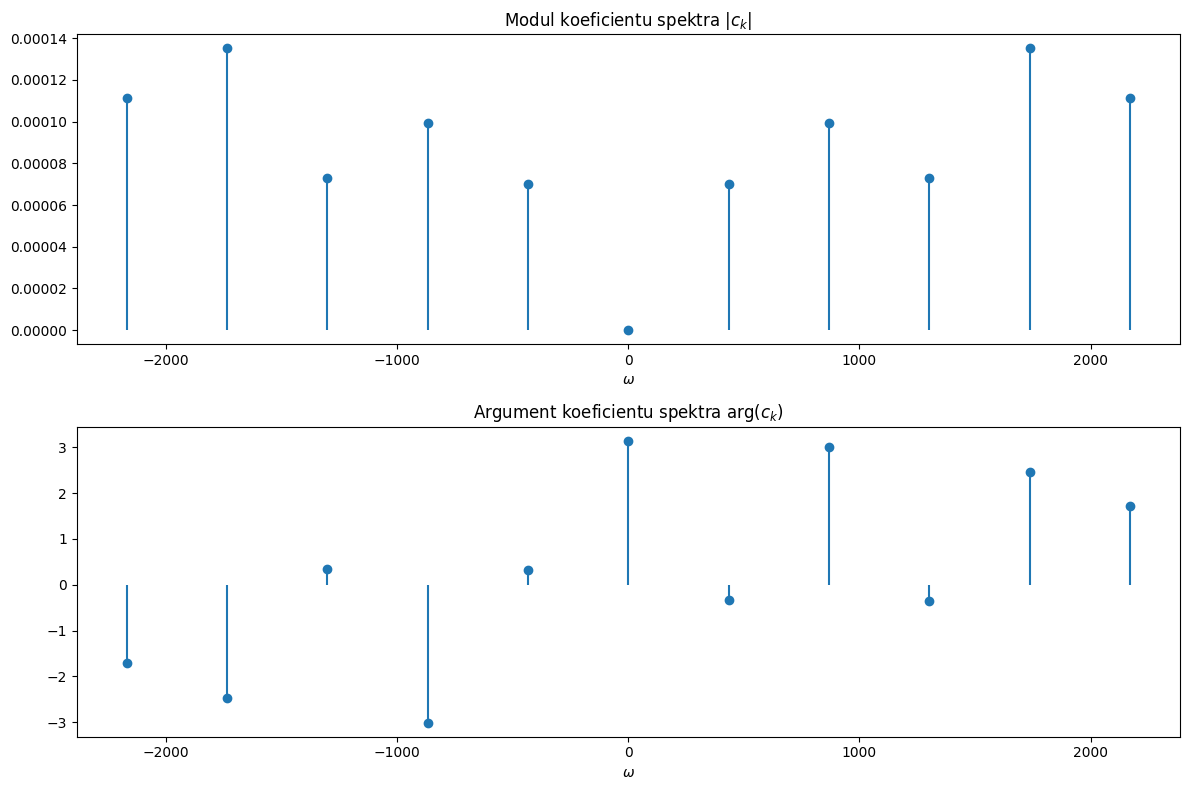

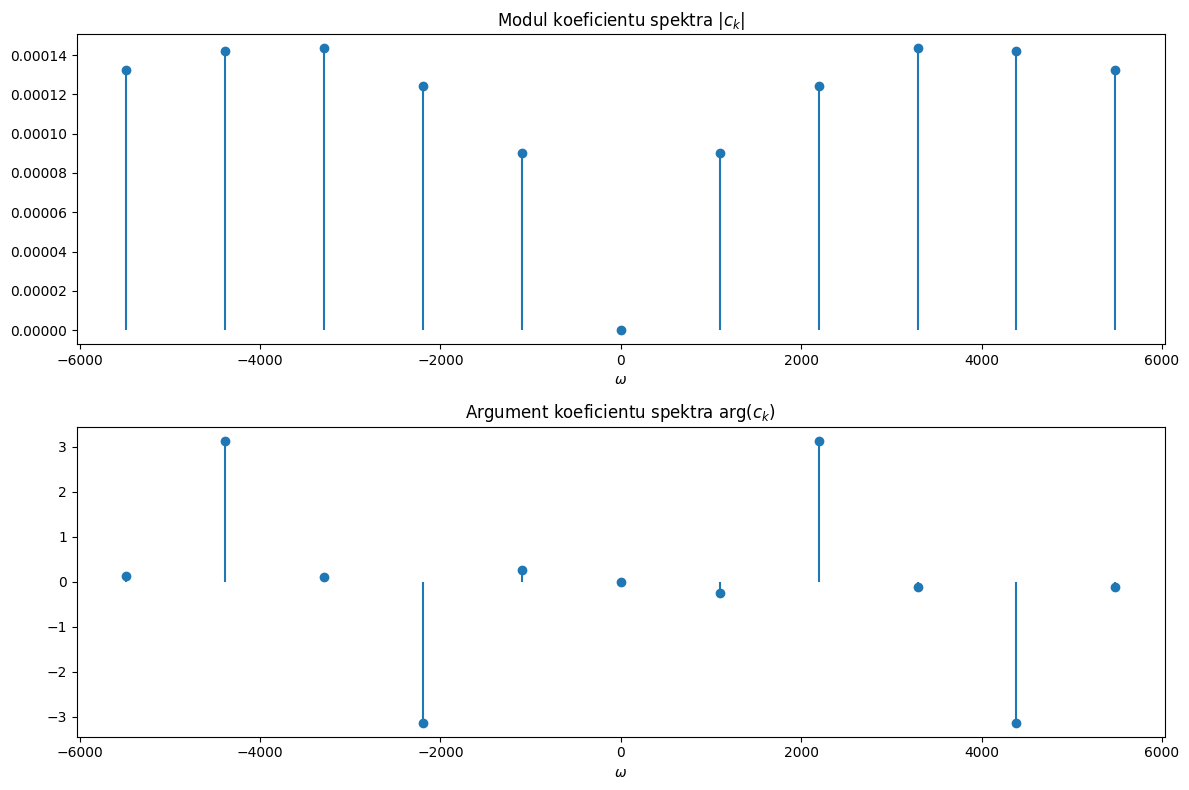

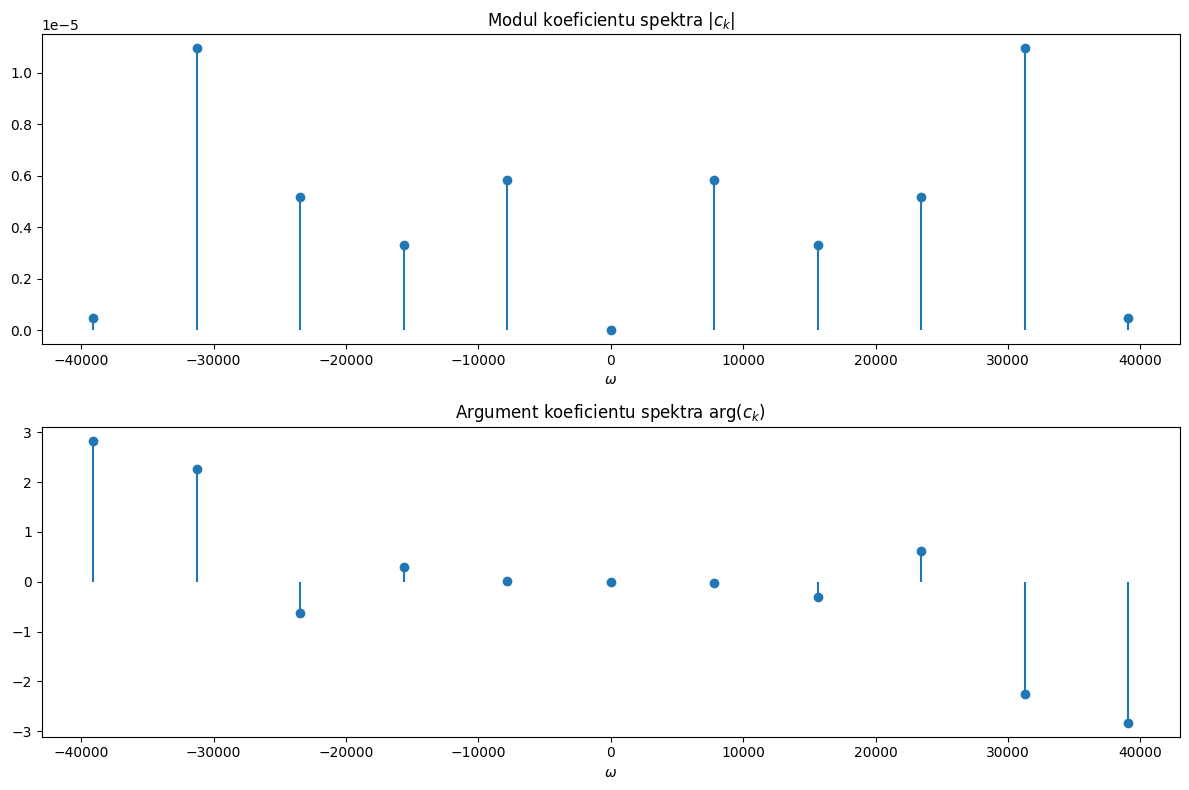

In [48]:
CKS = []
for i,tone in enumerate(MY_TONES):

    signal = xall[tone,:]    
    
    f1 = fACorr[tone]
    T1 = 1/f1
    t = np.linspace(-T1/2, T1/2, len(signal))
    omega1 = 2 * np.pi / T1
    k = np.arange(-5,6) # interval

    ck2 = []
    for kk in k:
        expo = np.exp(- 1j * kk * omega1 * t)
        # '* T1 / n_aprx' je tu kvuli aproximaci integralu 
        # pomoci n_aprx bodu v intervalu dlouhem T1
        ck2.append(np.dot(signal, expo) / len(signal))
    CKS.append(ck2)

    f, ax = plt.subplots(2, 1, figsize=(12, 8))

    ax[0].stem(k * omega1, np.abs(ck2), basefmt=' ')
    ax[0].set_title('Modul koeficientu spektra $|c_k|$')
    ax[0].set_xlabel('$\omega$')

    ax[1].stem(k * omega1, np.angle(ck2), basefmt=' ')
    ax[1].set_title('Argument koeficientu spektra $\mathrm{arg}(c_k)$')
    ax[1].set_xlabel('$\omega$')

    plt.tight_layout()


In [49]:
# module and phase
for i, tone in enumerate(MY_TONES):
    print('\033[1m' + f'\nTone MIDI {tone} : ' + '\033[0m')
    for ii in range(5):
        print(f'Module and phase {ii+1}f0:\t{np.round(np.real(CKS[i][ii+5]),8):.8f},      \t{np.round(np.angle(CKS[i][ii+5]),3):.3f} rad')




Tone MIDI 37 : 
Module and phase 1f0:	-0.00000000,      	3.142 rad
Module and phase 2f0:	0.00006636,      	-0.327 rad
Module and phase 3f0:	-0.00009833,      	3.010 rad
Module and phase 4f0:	0.00006862,      	-0.346 rad
Module and phase 5f0:	-0.00010516,      	2.463 rad

Tone MIDI 53 : 
Module and phase 1f0:	0.00000000,      	0.000 rad
Module and phase 2f0:	0.00008688,      	-0.261 rad
Module and phase 3f0:	-0.00012417,      	3.133 rad
Module and phase 4f0:	0.00014247,      	-0.112 rad
Module and phase 5f0:	-0.00014200,      	-3.134 rad

Tone MIDI 87 : 
Module and phase 1f0:	0.00000000,      	0.000 rad
Module and phase 2f0:	0.00000585,      	-0.018 rad
Module and phase 3f0:	0.00000315,      	-0.306 rad
Module and phase 4f0:	0.00000421,      	0.621 rad
Module and phase 5f0:	-0.00000696,      	-2.260 rad


## Excercise 4.5
<h3>
    <b>Syntéza tónov :</b>
</h3>

Syntéza signálov odpovedajúca našim troch tónov. <br>
Pre syntézu signálu sú vypočítané najskôr koeficienty Fourierovej rady, následne nastáva sčítanie cosínusoviek odvedených z koeficientov. <br>



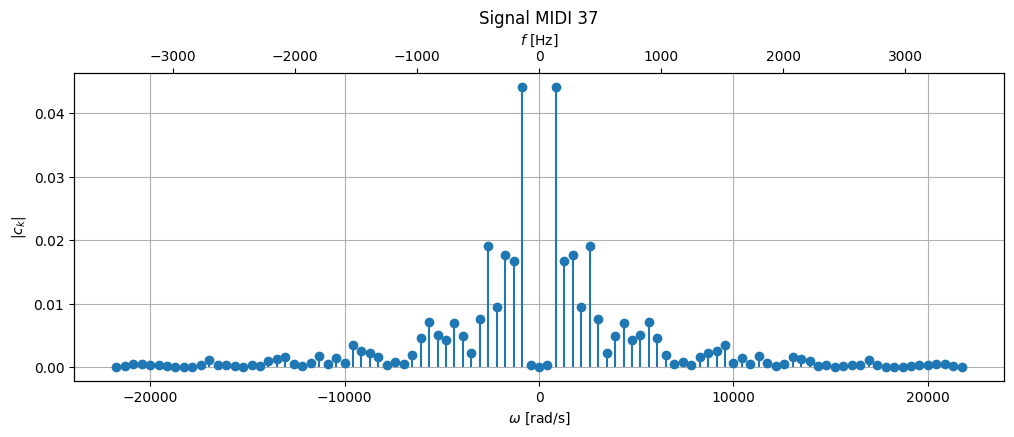

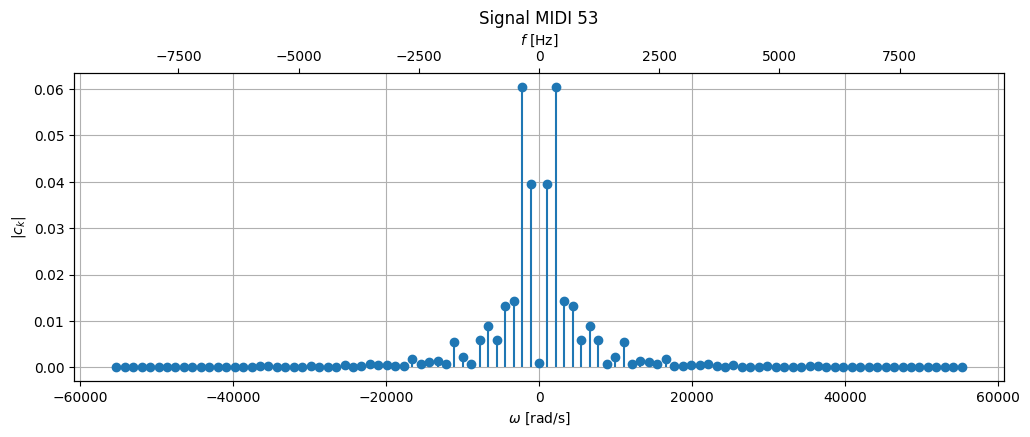

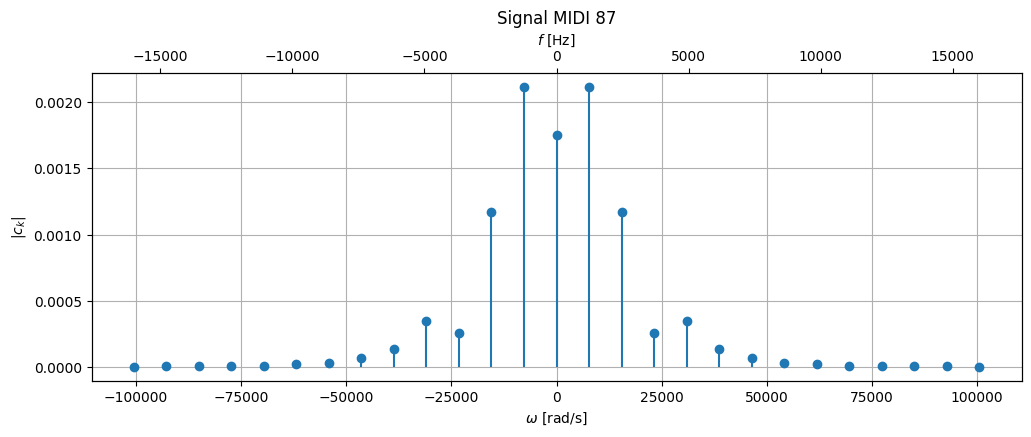

In [50]:

# -- koeficienty FR 
toneOnePeriod =[2080//3, 820//3, 118//3]
CKALL = []

for i,tone in enumerate(MY_TONES):
    N = toneOnePeriod[i]
    T1 = N / Fs
    f1 = 1 / T1 
    om1 = 2 * np.pi / T1

    X = np.fft.fftshift(np.fft.fft(xall[tone,:N])) 
    k0 = int((N-1)/ 2) if N % 2 == 1 else N / 2  ## pozor, funguje jen pro liche N !

    fLength = 50 if N > 50 * 3 else N // 3
    kall=np.arange(-fLength,fLength+1) 
    omall = kall * om1
    ckall = X[kall + k0] / N 
    CKALL.append(ckall)

    fig, ax = plt.subplots(figsize=(12,4))
    ax.stem(omall, np.abs(ckall),basefmt=" ")
    ax.set_title(f'Signal MIDI {tone}')
    ax.set_xlabel('$\omega$ [rad/s]')
    ax.set_ylabel('$|c_k|$')
    ax.grid()
    
    (minom,maxom)=ax.get_xlim()

    secax = ax.twiny()
    secax.set_xlim(minom / 2 / np.pi, maxom / 2 / np.pi)
    secax.set_xlabel('$f$ [Hz]')



Do grafov nižšie sa vykresľuje sčítanie cosínusoviek ktoré postupne lepššie a lepšie aproximujú hladaný tón. <br>
Z každého nami vygenerovaného tónu je vytvorená nahrávka o dĺžke 1 sekundy. <br>
Nahrávka sa dá buď pustiť zo scriptu, prípadne sa uloží do <i>"./audio/{a,b,c}.wav"</i>

c:\Users\marek\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


10 sekundova nahravka : /audio/a.wav


10 sekundova nahravka : /audio/b.wav


10 sekundova nahravka : /audio/c.wav


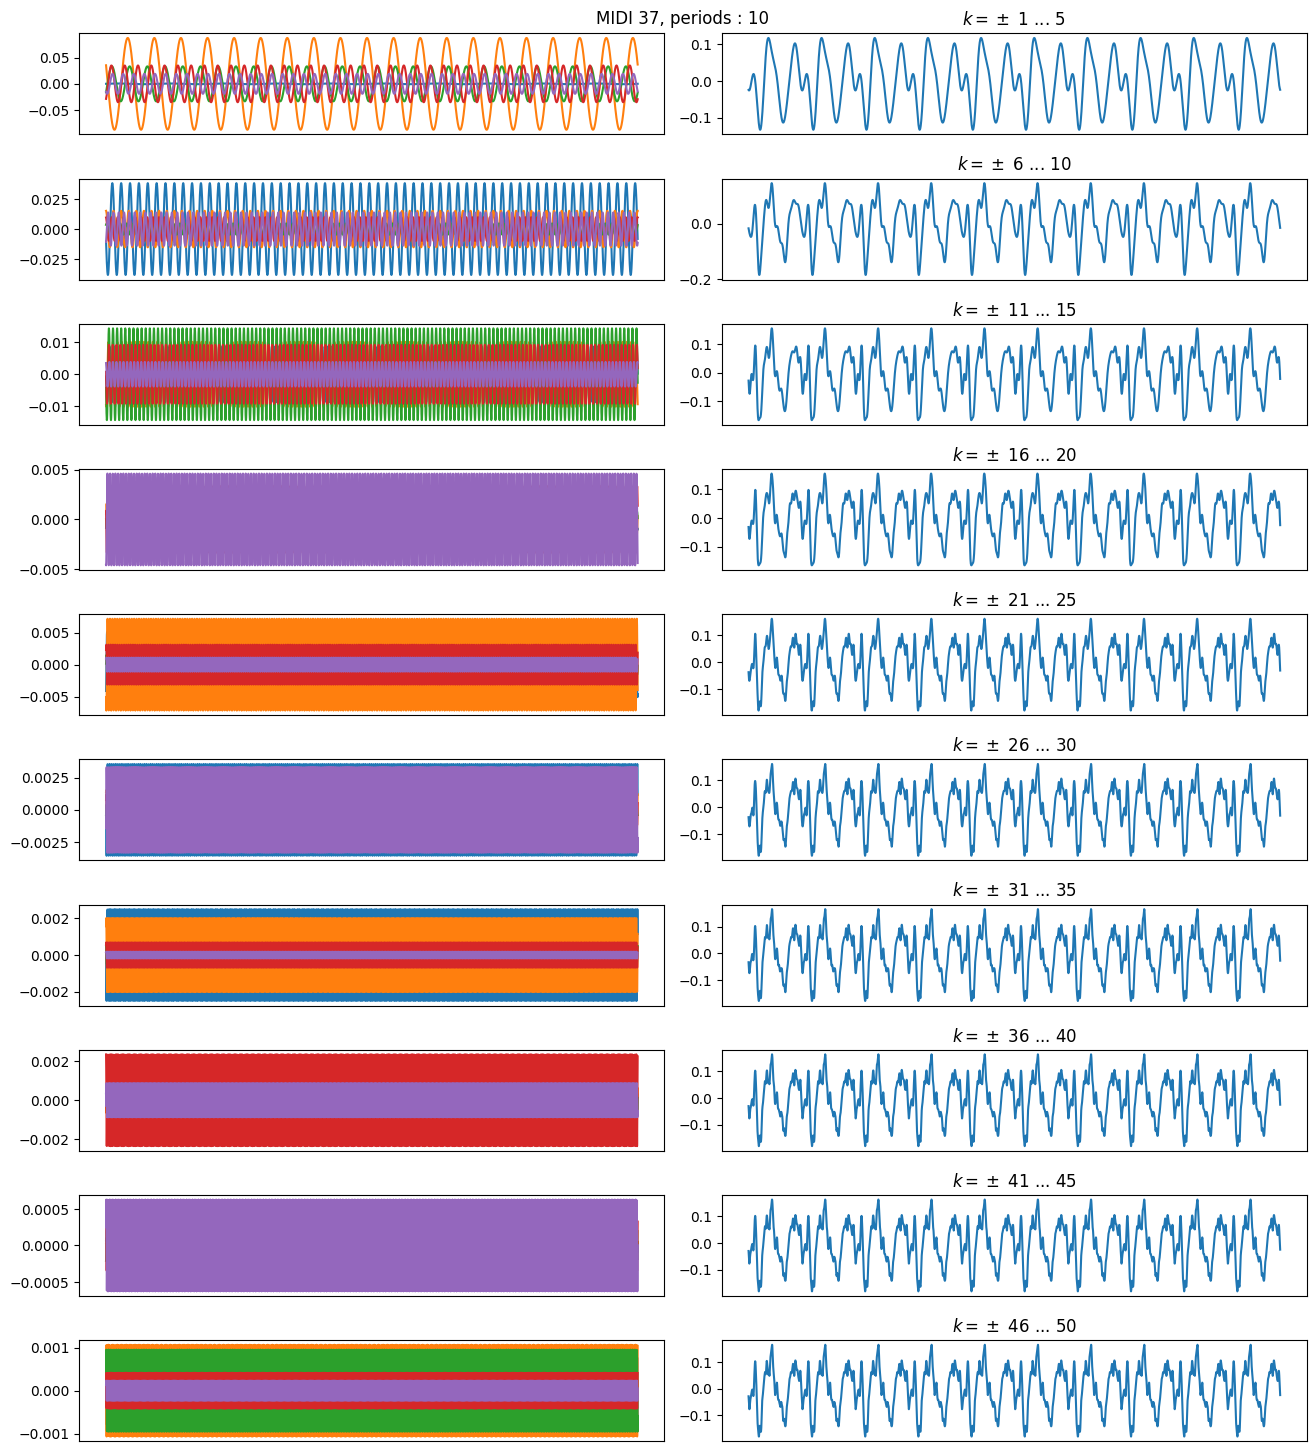

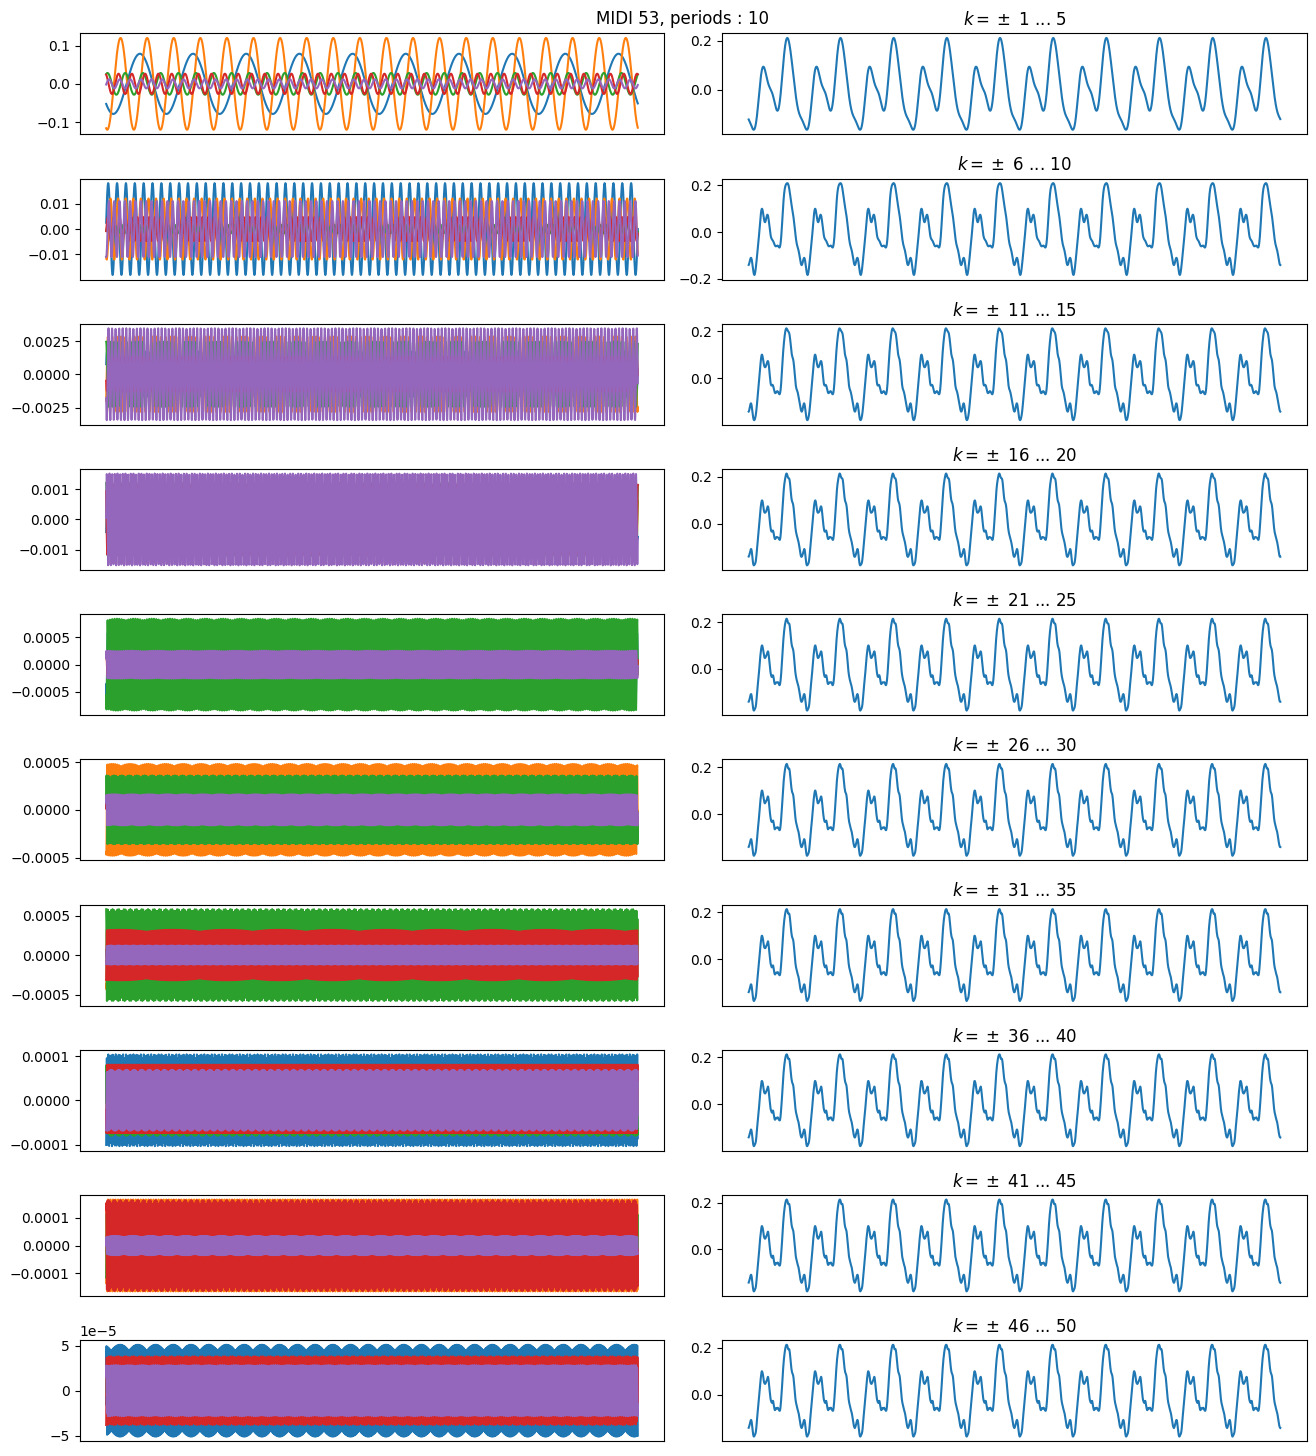

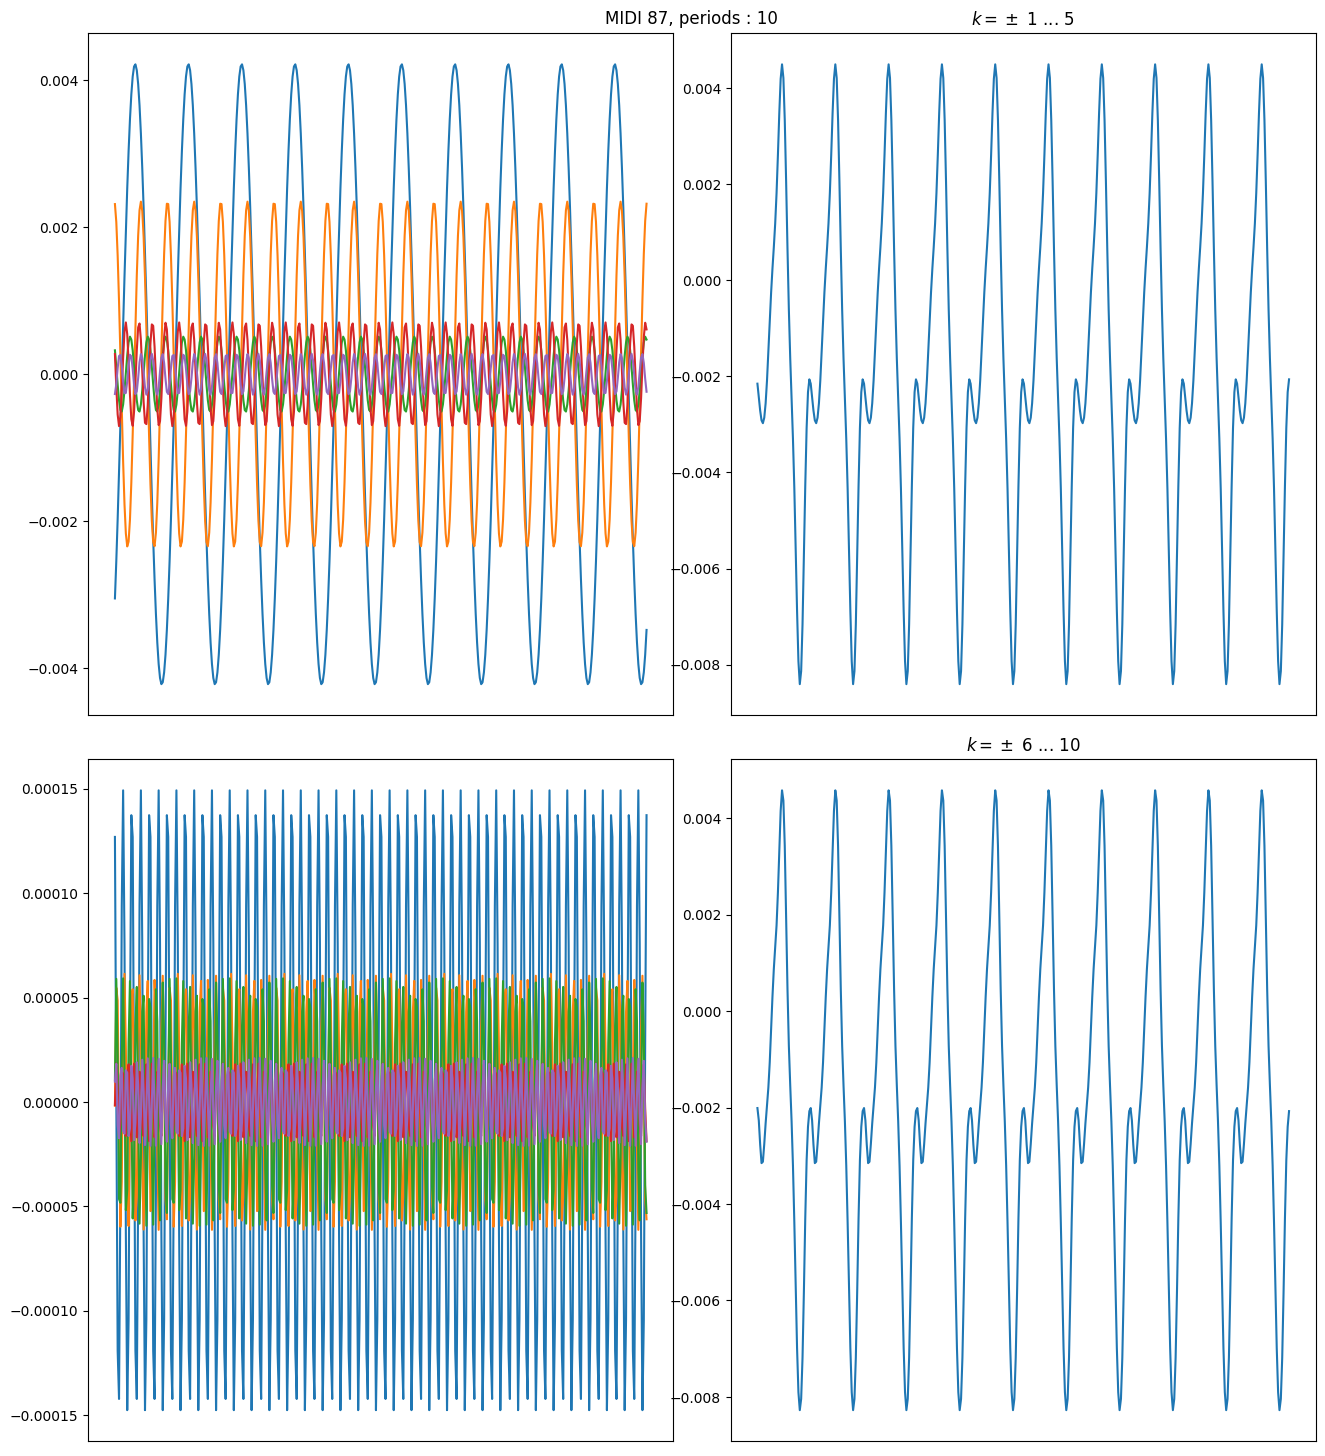

In [51]:
# definice casu a obrazku ...  
saveToneString = ['a','b','c']
generatedTones = []

for i, tone in enumerate(MY_TONES):
    ckall = CKALL[i]
    N = toneOnePeriod[i]
    T1 = N / Fs
    f1 = 1 / T1 
    om1 = 2 * np.pi / T1

    periodsToShow = 10
    t = np.arange(0, T1*periodsToShow, T1 / toneOnePeriod[i] )
    
    tplay = n = np.arange(0,(len(ckall)//2)*N) / Fs 
    kmax = len(ckall)//2

    maxFifeTuple = 10 if len(ckall) > 30 else 2

    fig, ax = plt.subplots(maxFifeTuple,2,figsize=(13,15))
    fig.suptitle(f'MIDI {tone}, periods : {periodsToShow}')
    fig.tight_layout()
    # initialization -- first the special case - d.c.
    yshow = ckall[kmax] * np.ones(t.size)
    yplay = ckall[kmax] * np.ones(tplay.size)
    
    for fivetuple in range(0,maxFifeTuple):  # takze do 10 ti ... 
        startk = fivetuple * 5 + 1
        endk = startk + 5  # this is too much but range will handle it ... 
        for k in range(startk, endk):
            #print(k)
            Ck = np.abs(ckall[kmax + k]*2)
            phik = np.angle(ckall[kmax + k])
            xshow = Ck * np.cos(k * om1 * t + phik)
            xplay = Ck * np.cos(k * om1 * tplay + phik)
            yshow = yshow + xshow
            yplay = yplay + xplay
            ax[fivetuple,0].plot(t,xshow)
            ax[fivetuple,0].set_xticks([])
        wavfname = "xx"+str(startk)+"_"+str(endk-1)+".wav"
        ax[fivetuple,1].plot(t,yshow)    
        ax[fivetuple,1].set_xticks([])
        ax[fivetuple,1].set_title('$k=\pm$ '+str(startk)+" ... "+str(endk-1))
        if k == 50 or maxFifeTuple==2 and k == 10:
            generatedTones.append(yshow)

    # Generating 1 second of signal 
    t = np.arange(0, 1, T1 / toneOnePeriod[i] )    
    tplay = n = np.arange(0, Fs) / Fs 
    kmax = len(ckall)//2
    yshow = ckall[kmax] * np.ones(t.size)
    yplay = ckall[kmax] * np.ones(tplay.size)
    for fivetuple in range(0,maxFifeTuple):  # takze do 10 ti ... 
        startk = fivetuple * 5 + 1
        endk = startk + 5  # this is too much but range will handle it ... 
        for k in range(startk, endk):
            #print(k)
            Ck = np.abs(ckall[kmax + k]*2)
            phik = np.angle(ckall[kmax + k])
            xshow = Ck * np.cos(k * om1 * t + phik)
            xplay = Ck * np.cos(k * om1 * tplay + phik)
            yshow = yshow + xshow
            yplay = yplay + xplay
        if k == 50 or maxFifeTuple==2 and k == 10 :
            wavfname = '/audio/'+str(saveToneString[i])+'.wav'
            print('10 sekundova nahravka : '+wavfname)
            sf.write( '.'+wavfname, np.real(yplay), Fs)
            IPython.display.display(IPython.display.Audio(np.real(yplay), rate=Fs))    
    


Porovnanie 10 periód vygenerovaného a nahraného tónu. <br>
Synchronizácia signálov bola vykonaná ručne. <br>
Z grafov je jasne badať ako reálna nahrávka si nedrží totožné vlastnosti počas celých 10 períod. <br>
Počiatočné periódy vygenerovaného signálu kopíruju nahrávka takmer ideálne. <br>  

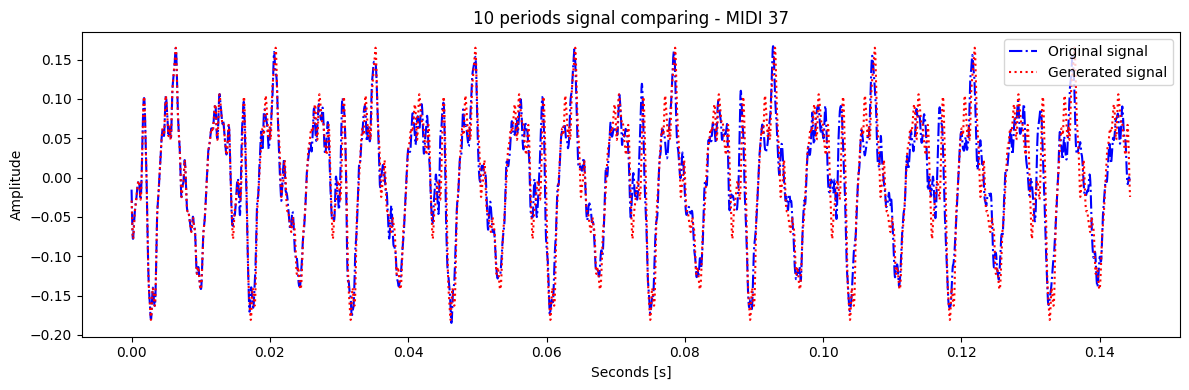

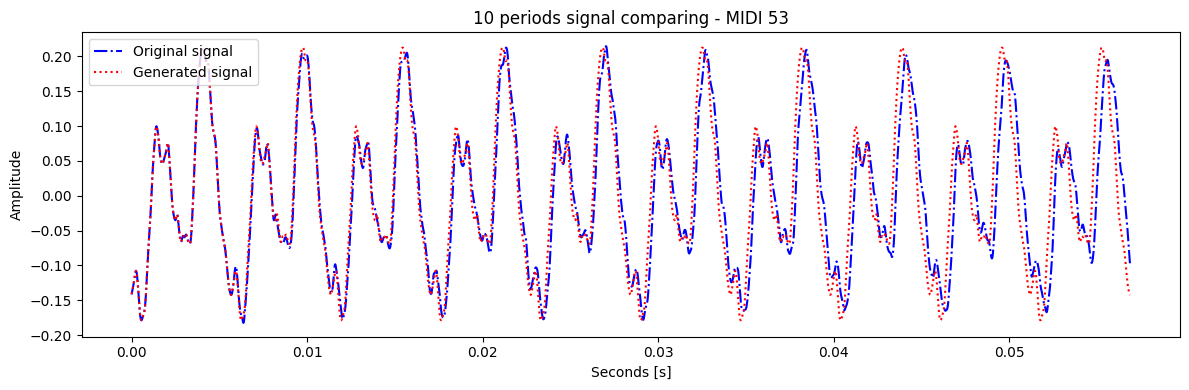

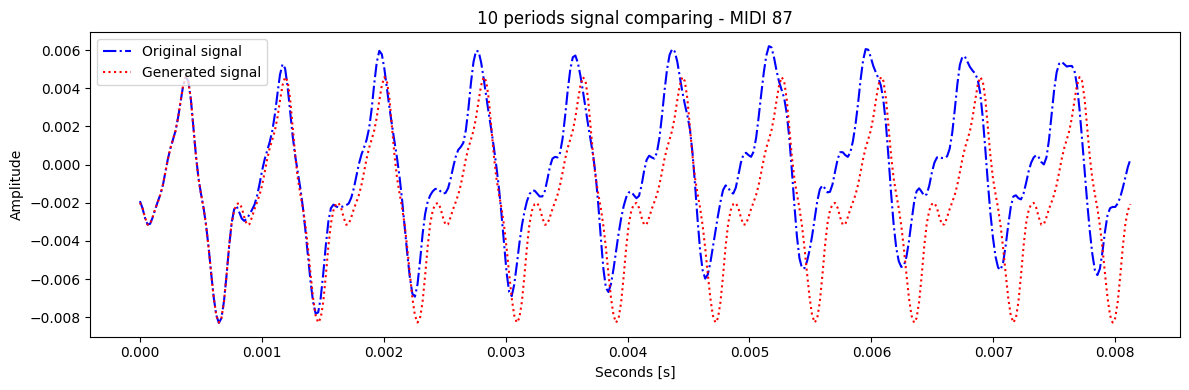

In [52]:
# Comparing Signals
for i,tone in enumerate(MY_TONES):
    genS = generatedTones[i]
    origS = xall[tone, :toneOnePeriod[i]*periodsToShow]
    
    plt.figure(figsize=[12,4])
    plt.plot(np.linspace(0, len(genS) / Fs, len(origS)), origS,'b-.')
    plt.plot(np.linspace(0, len(genS) / Fs, len(genS)), genS,'r:')
    plt.legend(['Original signal','Generated signal'])
    plt.xlabel('Seconds [s]')
    plt.ylabel('Amplitude')
    plt.title(f'10 periods signal comparing - MIDI {tone}')
    plt.tight_layout()


plt.show()




## Exercise 4.6
<h3>
    <b>Generovanie hudby :</b>
</h3>

Generovanie hudby ktoré je určené zo textového súboru "skladba.txt". <br>
Skladby sú vygenerované so vzorkovacou frekvenciou <b>48 kHz</b> a <b>8 kHz</b>. <br>
Z každej skladby bolo uložených 10 sekúnd do <i>"./audio/{out_48k,out_8k}.wav"</i>. <br>
<br>
Frekvenie pre vzorkovaciu frekvencie 8 kHz zo zadania netreba generovať, preto sa neporušuje vzorkovací teorém. <br>
Tóny signálu sú pred úpravou hladiny zvuku normalizované. <br>


In [53]:
song = pd.read_csv("skladba.txt", sep=" ", names=["from [ms]", "to [ms]", "midi", "volume"])
song["length [s]"] = (song["to [ms]"]-song["from [ms]"])/1000
song = song.sort_values("from [ms]")

In [54]:
SONG_MIDIS = song.sort_values(by = "midi")["midi"].unique()
SONG_VOLUME = song.sort_values(by = "volume")["volume"]


In [55]:
GENERATED_SONG_SIGNALS_48K = []
GENERATED_SONG_SIGNALS_8K = []
ALL_SIGNALS = [xall[midi] for midi in tones]
MY_SIGNALS = [xall[midi] for midi in MY_TONES]
ALL_MIDIS = tones[:]
ALL_FREQS = fACorr[:]

Fs48K = 48000
Fs8K = 8000

for i, signal in enumerate(ALL_SIGNALS):
    midi = ALL_MIDIS[i]
    if (midi in SONG_MIDIS):
        
        f1 = ALL_FREQS[i+24] # use estimated fundamental frequency
        T1 = 1/f1 # calculate the period from the fundamental frequency   
        
        N = int(Fs48K*T1)

        frange = np.min([N//2-1,50])

        kall=np.arange(-frange,frange+1) 

        om1 = 2 * np.pi * f1 # rads/s
        X = np.fft.fftshift(np.fft.fft(signal[:N])) 
        if N%2 == 0:
            k0 = int((N-1)/ 2) # for odd
        else:
            k0 = int(N/2) # for even

        omall = kall * om1
        AX_LEN = len(X)
        ckall = X[kall + k0] / N # calculated coeffsK for every k

        t = np.arange(0, T1, T1 / N)
        
        tplay = n = np.arange(0,(len(ckall)//2)*N) / Fs48K 
        kmax = len(ckall)//2

        yshow = ckall[kmax] * np.ones(t.size)
        yplay = ckall[kmax] * np.ones(tplay.size)
            
        for k in range(len(ckall)-kmax):
            Ck = np.abs(ckall[kmax + k]*2)
            phik = np.angle(ckall[kmax + k])
            xshow = Ck * np.cos(k * om1 * t + phik)
            xplay = Ck * np.cos(k * om1 * tplay + phik)
            yshow = yshow + xshow
            yplay = yplay + xplay            

        yshow48K = np.tile(yshow, 4*int(Fs48K/(len(yshow)*2)))
        GENERATED_SONG_SIGNALS_48K.append(np.real(yshow48K))
        
for i, signal in enumerate(ALL_SIGNALS):
    midi = ALL_MIDIS[i]
    if (midi in SONG_MIDIS):
        
        f1 = ALL_FREQS[i+24] # use estimated fundamental frequency
        T1 = 1/f1 # calculate the period from the fundamental frequency   
        
        N = int(Fs8K*T1)

        frange = np.min([N//2-1,50])

        kall=np.arange(-frange,frange+1) 

        om1 = 2 * np.pi * f1 # rads/s
        # signal = signal[::int(Fs48K/Fs8K)] 
        X = np.fft.fftshift(np.fft.fft(signal[:N])) 
        # 
        if N%2 == 0:
            k0 = int((N-1)/ 2) # for odd
        else:
            k0 = int(N/2) # for even

        omall = kall * om1
        AX_LEN = len(X)
        ckall = X[kall + k0] / N # calculated coeffs for every k

        t = np.arange(0, T1, T1 / N)
        
        tplay = n = np.arange(0,(len(ckall)//2)*N) / Fs8K 
        kmax = len(ckall)//2

        yshow = ckall[kmax] * np.ones(t.size)
        yplay = ckall[kmax] * np.ones(tplay.size)
            
        for k in range(len(ckall)-kmax):
            Ck = np.abs(ckall[kmax + k]*2)
            phik = np.angle(ckall[kmax + k])
            xshow = Ck * np.cos(k * om1 * t + phik)
            xplay = Ck * np.cos(k * om1 * tplay + phik)
            yshow = yshow + xshow
            yplay = yplay + xplay            

        yshow48K = np.tile(yshow, 4*int(Fs48K/(len(yshow)*2)))
        yshow8K = np.tile(yshow, 4*int(Fs8K/(len(yshow)*2)))
        if (f1 < Fs8K/2):
            GENERATED_SONG_SIGNALS_8K.append(np.real(yshow8K))        
        else:
            print(f1, Fs8K, f1<Fs8K/2)


In [38]:
DURATION = 10 # seconds
SIGNALS_TEMP48K_norm = []
SIGNALS_TEMP8K_norm = []


for _, row in song.iterrows():   
   volume = row["volume"] / 100

   for i, midi in enumerate(SONG_MIDIS):
      if midi == row["midi"]:

         array48K_norm = np.zeros(int(Fs48K*DURATION))
         samplefrom48K_norm = int(Fs48K*row["from [ms]"]/1000)
         sampleto48K_norm = int(Fs48K*row["to [ms]"]/1000)  
         if samplefrom48K_norm <= array48K_norm.shape[0] and sampleto48K_norm <= array48K_norm.shape[0]: 
            totalsamples48K_norm = sampleto48K_norm-samplefrom48K_norm
            for j in range(samplefrom48K_norm, sampleto48K_norm):
               array48K_norm[j] = GENERATED_SONG_SIGNALS_48K[i][j-samplefrom48K_norm]
            volume_norm_48K = np.max(np.abs(array48K_norm)) * volume
            SIGNALS_TEMP48K_norm.append(array48K_norm * volume_norm_48K)

         array8K_norm = np.zeros(int(Fs8K*DURATION))
         samplefrom8K_norm = int(Fs8K*row["from [ms]"]/1000)
         sampleto8K_norm = int(Fs8K*row["to [ms]"]/1000)
         if samplefrom8K_norm <= array8K_norm.shape[0] and sampleto8K_norm <= array8K_norm.shape[0]: 
            totalsamples8K_norm = sampleto8K_norm-samplefrom8K_norm
            for j in range(samplefrom8K_norm, sampleto8K_norm):
               array8K_norm[j] = GENERATED_SONG_SIGNALS_8K[i][j-samplefrom8K_norm] * volume
            volume_norm_8K = np.max(np.abs(array8K_norm)) * volume
            SIGNALS_TEMP8K_norm.append(array8K_norm * volume_norm_8K)


In [39]:
SIGNAL_48K_norm = [sum(x) for x in zip(*SIGNALS_TEMP48K_norm)]
SIGNAL_8K_norm = [sum(x) for x in zip(*SIGNALS_TEMP8K_norm)]


In [40]:
print(f"Signal 48K_normHz :")
out_48k_norm = IPython.display.display(IPython.display.Audio(SIGNAL_48K_norm, rate=Fs48K))
sf.write(f'audio/out_48k.wav', SIGNAL_48K_norm, Fs48K)

print(f'Signal 8K_normHz :')
out_8k_norm = IPython.display.display(IPython.display.Audio(SIGNAL_8K_norm, rate=Fs8K))
sf.write(f'audio/out_8k.wav', SIGNAL_8K_norm, Fs8K)




Signal 48K_normHz :


Signal 8K_normHz :


## Exercise 4.7
<h3>
    <b>Spektrogram :</b>
</h3>

Spektrogram prvých 10 sekúnd vygenerovaného signálu. <br>
Spektrogram je vygenerovaný :<br>
<ul>
    <li>48 KHz </li>
    <li>8 KHz </li>
</ul>

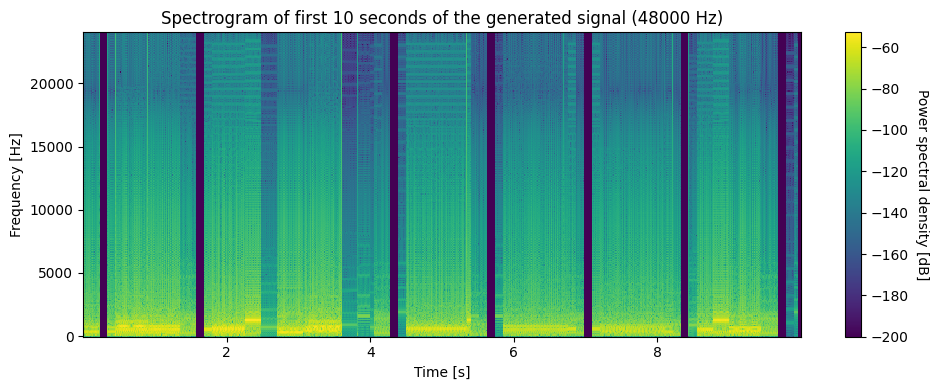

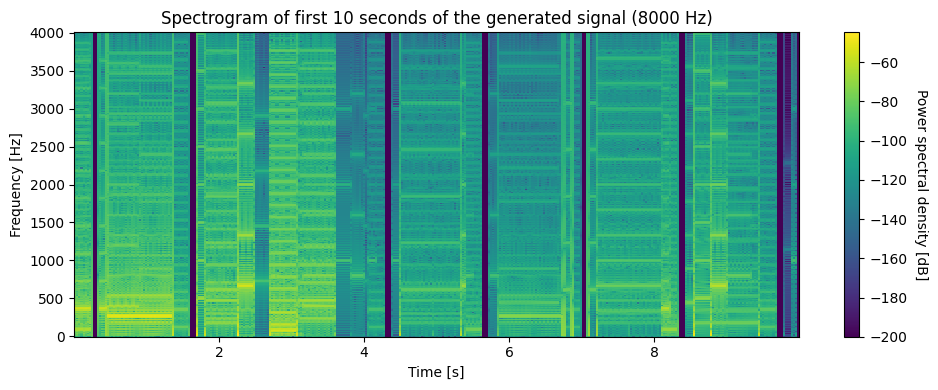

In [55]:
from scipy.signal import spectrogram
signalsALL = [SIGNAL_48K_norm, SIGNAL_8K_norm]
freqSignalDunnoAll = [ 48000, 8000]

for i,Fs in enumerate(freqSignalDunnoAll):

    dftNum = 2048 if freqSignalDunnoAll==48000 else 512

    f, t, sgr = spectrogram(np.array(signalsALL[i]), Fs, window=('tukey', 0.03), noverlap=None, nfft=dftNum)
    sgr_log = 10 * np.log10(sgr+1e-20) 
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t,f,sgr_log)
    plt.gca().set_xlabel('Time [s]')
    plt.gca().set_ylabel('Frequency [Hz]')
    cbar = plt.colorbar()
    cbar.set_label('Power spectral density [dB]', rotation=270, labelpad=15)
    plt.title(f"Spectrogram of first 10 seconds of the generated signal ({Fs} Hz)")
    plt.tight_layout()